# 데이터 이해하기, 어떻게 분석할지 고민하기, 준비하기

In [1]:
!samtools view ../datapack/CLIP-35L33G.bam | head -6

SRR458758.23028115	0	chr1	3056473	0	20M	*	0	0	GAATGGAAGTTCAAGGATCT	HHGHHGE@GGHHED?GEGDG	MD:Z:20	NH:i:40	HI:i:1	NM:i:0	SM:i:0	XQ:i:40	X2:i:40	XO:Z:UM	XS:A:-
SRR458758.23879202	0	chr1	3056473	0	20M	*	0	0	GAATGGAAGTTCAAGGATCT	GBGGEEAAF=CEEDEGBGG>	MD:Z:20	NH:i:40	HI:i:1	NM:i:0	SM:i:0	XQ:i:40	X2:i:40	XO:Z:UM	XS:A:-
SRR458758.23893532	0	chr1	3056473	0	20M	*	0	0	GAATGGAAGTTCAAGGATCT	G@?GGE=EFBDDGGGGD@GG	MD:Z:20	NH:i:40	HI:i:1	NM:i:0	SM:i:0	XQ:i:40	X2:i:40	XO:Z:UM	XS:A:-
SRR458758.26501547	0	chr1	3056473	0	20M	*	0	0	GAATGGAAGTTCAAGGATCT	IIIHIIIHIGHIIIHEHIHH	MD:Z:20	NH:i:40	HI:i:1	NM:i:0	SM:i:0	XQ:i:40	X2:i:40	XO:Z:UM	XS:A:-
SRR458758.685997	16	chr1	3059006	0	22M	*	0	0	TTCATTTACAGAATGGAATACT	EG7:776DGGGBD<GGEBGEG@	MD:Z:22	NH:i:30	HI:i:1	NM:i:0	SM:i:0	XQ:i:40	X2:i:40	XO:Z:UM	XS:A:+
SRR458758.12045118	16	chr1	3059006	0	22M	*	0	0	TTCATTTACAGAATGGAATACT	IFGIDDIHIHEIIIIIIIIHBI	MD:Z:22	NH:i:30	HI:i:1	NM:i:0	SM:i:0	XQ:i:40	X2:i:40	XO:Z:UM	XS:A:+
samtools view: writing to standard output failed: Broken

In [2]:
!samtools view ../datapack/CLIP-35L33G.bam | wc -l

 38880853


* 일단 `MD:Z:`부분이 mismatch를 표시하고 있기 때문에, 이 부분의 정보를 가지고 read 위치별 error frequency를 구하는 방법으로 진행한다.
1. read length별 read count정보를 통하여 각 read idex별로 total base count를 구한다.
2. 38880853 개의 read alignmnet정보에서 각 MD tag를 추출한다.
3. MD에서 지시하고 있는 error index별 error base 정보를 모은다. 
4. 1과 3을 이용하여 index별 error frequency를 구한다.

## total counts for each read index

```{python}
!samtools view ../datapack/CLIP-35L33G.bam | \
 awk '{print length($10)}' | sort | uniq -c | awk '{print $2","$1}' > wholeReadlen.txt
 ```

In [2]:
!head -3 wholeReadlen.txt
!tail -3 wholeReadlen.txt

20,1285348
21,1203488
22,1202998
73,83219
74,121198
75,150140


* 가장 짧은 read가 20정도, 가장 긴 read가 75정도이다.
* 그래서 길이가ㅏ 80정도되는 빈리스트를 만들어서 각 read position index별로 count값을 담아본다.

In [4]:
open("wholeReadlen.txt", "r").readline().split(",")

['20', '1285348\n']

In [5]:
len(open("wholeReadlen.txt", "r").readlines())

56

In [7]:
totalPosCountlist =[]
for i in range(80):
    totalPosCountlist.append([])

lenf = open("wholeReadlen.txt", "r")
for i in range(56):
    readlen, readnum = lenf.readline().split(",")
    totalPosCountlist[int(readlen)-1] = int(readnum)

lenf.close()

# put same value till position 20
for i in range(20):
    totalPosCountlist[i] = 1285348

totalPosCountlist[70:]

[85594, 80883, 83219, 121198, 150140, [], [], [], [], []]

In [8]:
#put 1 on the remained position (for division)
for i in range(75,80):
    totalPosCountlist[i] = 1
totalPosCountlist[75:80]

[1, 1, 1, 1, 1]

## extract MD tag from each read

* 원래의 `CLIP-35L33G.bam`파일은 너무 크기 때문에, 가장 작은 chrM만 가지고 연습을 먼저 해보기로하였다.

In [13]:
!samtools view -b -o CLIP-chrM.bam ../datapack/CLIP-35L33G.bam chrM
!samtools view CLIP-chrM.bam | head -3

SRR458758.537185	0	chrM	4	39	24M	*	0	0	AATGTGGCTTAATAACAAAGCAAA	BGGGGHHHHHHHHHGBBGGGHDHH	MD:Z:5A18	NH:i:1	HI:i:1	NM:i:1	SM:i:39	XQ:i:40	X2:i:0	XO:Z:UU	XS:A:+	XY:Z:+ENSMUST00000082387.1:4..27
SRR458758.2572947	0	chrM	4	39	24M	*	0	0	AATGTGGCTTAATAACAAAGCAAA	HDHGHHFFHHBBGGGFFDGDDHHH	MD:Z:5A18	NH:i:1	HI:i:1	NM:i:1	SM:i:39	XQ:i:40	X2:i:0	XO:Z:UU	XS:A:+	XY:Z:+ENSMUST00000082387.1:4..27
SRR458758.7266053	0	chrM	4	38	24M	*	0	0	AATGTGGCTTAATAACAAAGCAAA	=D@DGCBDGDGDDDGGEGDADDED	MD:Z:5A18	NH:i:1	HI:i:1	NM:i:1	SM:i:38	XQ:i:40	X2:i:0	XO:Z:UU	XS:A:+	XY:Z:+ENSMUST00000082387.1:4..27
samtools view: writing to standard output failed: Broken pipe
samtools view: error closing standard output: -1


In [16]:
!samtools view -h CLIP-chrM.bam | grep "MD:Z:" | sed 's/.*MD:Z:\([ACGTI^0-9]*\).*/\1/' | head -3 

5A18
5A18
5A18
sed: stdout: Broken pipe


* 위 sed 프로그램에 사용한 정규식이 일단은 working하는 것 같으니까 이걸로 전체 파일에서 MDtag만 filter해본다

```{Python}
!samtools view ../datapack/CLIP-35L33G.bam | grep "MD:Z:" | sed 's/.*MD:Z:\([ACGTI^0-9]*\).*/\1/' > MDflag_full.txt
```

In [17]:
!wc -l MDflag_full.txt

 36589778 MDflag_full.txt


In [18]:
!head -3 MDflag_full.txt
!tail -3 MDflag_full.txt

20
20
20
47
6^T3G17
6^T3G17


## pileup errors for each read position (not reference)

* 위와 동일하게 길이 80인 빈 리스트 `reslist`를 마련해 두고, mdflag에 표기되어있는 error를 순차적으로 추출하여 `reslist`에 저장한다. 각 read의 5'-end 의 첫번째 base 위치가 `reslist`의 0위치에 해당한다.

In [9]:
reslist =[]
for i in range(80):
    reslist.append([])

* 혹시 모르니 한번 랜덤으로 생성한 MDflag 예제로 정규식을 이용하여 MDtag에서 position별 error를 추출하는 테스트를 해본다

In [10]:
import re

# regex pattern to split MDflag by each error
p = re.compile("[0-9]+[\^]*[ACGT]+")

# test to get error information from one MDflag (one line in BAM)
mdflag = "15G4C30^CC0A18" # MDflag example

temp = []
errorI = 0
for err in p.findall(mdflag):
    matchN = int(re.search("[0-9]+",err).group())
    errorI += matchN + 1
    errorB = re.search("[\^ACGT]+", err).group()
    temp.append((errorI, errorB))
    if errorB.startswith("^"):
        errorI -= 1
temp

[(16, 'G'), (21, 'C'), (52, '^CC'), (52, 'A')]

* 각 라인별로 MDflag를 추출하면 거기서 각각의 error 위치와 뉴크레오타이드를 튜플 리스트로 추출해줄 함수를 작성한다.
* MDtag에서 ^[ACGT]+로 표기되는 deletion error의 경우에는 read에서 빠진 bases이므로 index를 하나씩 빼서 작동하도록 하였다.
* insertion error의 경우는 일단 무시하였다 (`Think later`부분에서 이에 대한 고찰)

In [11]:
def Err_eachMDflag(mdflag):
    p = re.compile("[0-9]+[\^]*[ACGT]+")
    
    temp=[]
    errorI = 0
    for err in p.findall(mdflag):
        matchN = int(re.search("[0-9]+",err).group())
        errorI += matchN + 1
        errorB = re.search("[\^ACGT]+", err).group()
        temp.append((errorI, errorB))
        if errorB.startswith("^"):
            errorI -= 1
    return temp

* 작성한 함수를 활용하여 결과리스트를 도출하는 과정 테스트

In [12]:
test = ["5G2^CC2A10", "20", "8A0C8", "0A16"]

testlist =[]
for i in range(15):
    testlist.append([])
    
    
for eachMD in test:
    errList = Err_eachMDflag(eachMD)
    for i, b in errList:
        testlist[i-1].append(b)

testlist

[['A'],
 [],
 [],
 [],
 [],
 ['G'],
 [],
 [],
 ['^CC', 'A'],
 ['C'],
 ['A'],
 [],
 [],
 [],
 []]

* 전체 read의 MD flag에서 read포지션별 error를 추출하여 `reslist`에 넣어본다

In [19]:
import time
start = time.time()

f = open("MDflag_full.txt", "r")
for i in range(36589778):
    eachMD = f.readline()
    errList = Err_eachMDflag(eachMD)
    for i, b in errList:
        reslist[i-1].append(b)
f.close()

print("time: ", time.time() - start)

In [20]:
len(reslist[0])

267533

## calculation of error frequency

 * error type 상관없이 error frequency는 그냥 단순하게 각 index의 길이만 세면 된다.
 * 그런데 이 `reslist` 결과를 보면.. ^[ACGT]+로 표기되는 deletion error말고도 [ACGT]+ 패턴이 있는 것 같다.. (원래는 0A0C..이런식으로 연속 substitution도 0을 써주면서 연속표기되는 줄 알았는데..) 이 부분에 대한 내용은 나중에 `Think later`에서 더 알아보기로한다.

In [25]:
SubDelErrCount = [len(errPos) for errPos in reslist]
SubDelErrCount

[267533,
 132334,
 277228,
 342529,
 352134,
 342165,
 338749,
 320153,
 476690,
 456972,
 486573,
 443263,
 463812,
 632050,
 784825,
 807791,
 949670,
 903027,
 1148854,
 801559,
 860417,
 708028,
 849315,
 560239,
 508444,
 524817,
 459289,
 407409,
 359747,
 359751,
 302683,
 266961,
 255351,
 250757,
 215874,
 194178,
 181786,
 165709,
 158179,
 128189,
 106933,
 96162,
 88312,
 80199,
 84463,
 69052,
 54792,
 55722,
 42474,
 39438,
 36496,
 32702,
 26760,
 25887,
 21151,
 18152,
 17554,
 20925,
 21910,
 12045,
 8963,
 7211,
 6624,
 6123,
 4954,
 4514,
 3551,
 3138,
 2206,
 1905,
 1224,
 1378,
 1231,
 856,
 154,
 0,
 0,
 0,
 0,
 0]

* read position 별로 축적한 error 정보인 `reslist`에서 Deletion error와 Substitution error를 구분해서 count하였다.

In [26]:
DelErrCount = [sum(1 if eacherr.startswith("^") else 0 for eacherr in errPos) \
               for errPos in reslist]
SubErrCount = [sum(0 if eacherr.startswith("^") else 1 for eacherr in errPos) \
               for errPos in reslist]

* 전체 중에 error count를 나누어서 error frequency를 계산하기 위해 각 read position별로 몇개의 read가 있는지 세보려고 한다.
* bam파일에서 모든 read length를 count한 다음 이를 `reslist`처럼 1~80까지의 값을 가지는 리스트로 만들었다 `totalPosCountlist`.

In [27]:
SubDelErrFreq = np.array(SubDelErrCount)/np.array(totalPosCountlist)
SubDelErrFreq

array([0.20814052, 0.10295578, 0.21568322, 0.26648736, 0.27396005,
       0.26620417, 0.26354653, 0.24907885, 0.37086454, 0.35552395,
       0.37855351, 0.34485836, 0.36084547, 0.49173453, 0.6105934 ,
       0.62846093, 0.73884271, 0.70255448, 0.89380775, 0.62361244,
       0.71493609, 0.58855293, 0.69755609, 0.41328209, 0.3816279 ,
       0.36700977, 0.33645894, 0.31431078, 0.27165602, 0.29071751,
       0.26940214, 0.23427681, 0.21538102, 0.24009326, 0.20108407,
       0.1821084 , 0.17251553, 0.13859741, 0.13024079, 0.07649143,
       0.13355573, 0.12677265, 0.12560858, 0.11283429, 0.1053504 ,
       0.07020833, 0.09006272, 0.09096088, 0.06250653, 0.0469357 ,
       0.07743228, 0.07562153, 0.0669256 , 0.06534069, 0.0694783 ,
       0.06149051, 0.06375691, 0.0872624 , 0.0868786 , 0.03958512,
       0.03834586, 0.03190779, 0.03810948, 0.03897716, 0.03389088,
       0.03362183, 0.0320418 , 0.03043352, 0.02448744, 0.0207505 ,
       0.01430007, 0.01703695, 0.0147923 , 0.00706282, 0.00102

In [28]:
SubErrFreq =  np.array(SubErrCount)/np.array(totalPosCountlist)
DelErrFreq =  np.array(DelErrCount)/np.array(totalPosCountlist)

* 논문의 그래프에서는 read postion을 20bins로 나누어 x축이 표현됬다고 한다.
* 일단 길이가 80이니까 4개씩 묶어서 error frequency를 sum해서 그려보자

In [33]:
SubErrFreq_20bins = [sum(SubErrFreq[num:num+4]) for num in range(0,80,4)]
DelErrFreq_20bins = [sum(DelErrFreq[num:num+4]) for num in range(0,80,4)]

In [ ]:
list(range(0,81,4))

In [30]:
sum(SubErrFreq[0:4])

0.7929844680195558

* error type별로 base-specific frequency도 뽑아보자

# 그래프 그리기

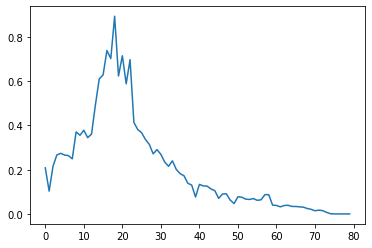

In [35]:
from matplotlib import pyplot as plt

x = list(range(80))	
y = SubDelErrFreq	
plt.plot(x, y)	
plt.show()	

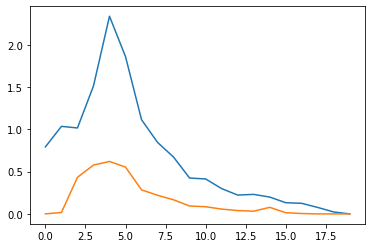

In [37]:
x = list(range(20))	
y1 = SubErrFreq_20bins
y2 = DelErrFreq_20bins
plt.plot(x, y1)	
plt.plot(x, y2)	
plt.show()	

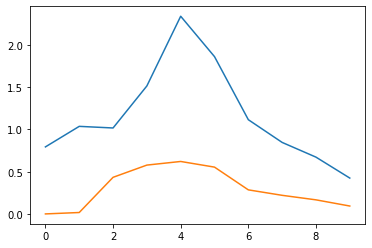

In [38]:
x = list(range(10))	
y1 = SubErrFreq_20bins[:10]
y2 = DelErrFreq_20bins[:10]
plt.plot(x, y1)	
plt.plot(x, y2)	
plt.show()	

## Think later

* MDtag에서 안잡히는 Insertion error를 무시해도 되는지 (무시해도 될만큼 빈도가 적을 지)알아보자

In [126]:
!samtools view ../datapack/CLIP-35L33G.bam | cut -f 6 | grep "I" | wc -l

   80873


In [127]:
print(80873/38880853)

0.002080021238217176


* 연속적으로 있는 I error는?

* 작업을 진행하다가 이상하거다 더 확인이 필요한 부분은 여기 남겨놓았다가 나중에 생각하기

In [83]:
!samtools view ../datapack/CLIP-35L33G.bam | grep "MD:Z:0CTG" | head -3

SRR458758.626397	256	chr1	4911719	0	40M	*	0	0	ACTCTCTTCCAAAGGTCCTGAGTTCAAATCCCAGCAACCA	?141>:76:=:95/-,:6?@85/?46?66?6=*-//:1/+	MD:Z:0CTG37	NH:i:67	HI:i:16	NM:i:3	SM:i:0	XQ:i:22	X2:i:40	XO:Z:UM	XS:A:+	XY:Z:+ENSMUST00000141278.2:3125..3164
SRR458758.1222986	256	chr1	4911719	0	40M	*	0	0	ACTCTCTTCCAAAGGTCCTGAGTTCAAATCCCAGCAACCA	IIIIIIHIIIIIIGIIIIIIIIIIIIIIIIIIIHEIHIHI	MD:Z:0CTG37	NH:i:67	HI:i:16	NM:i:3	SM:i:0	XQ:i:9	X2:i:40	XO:Z:UM	XS:A:+	XY:Z:+ENSMUST00000141278.2:3125..3164
SRR458758.2730793	256	chr1	4911719	0	40M	*	0	0	ACTCTCTTCCAAAGGTCCTGAGTTCAAATCCCAGCAACCA	IIIIIIIIIIIIIIIIIIIIHIIIIIIIIIIIIIIIIIII	MD:Z:0CTG37	NH:i:67	HI:i:16	NM:i:3	SM:i:0	XQ:i:9	X2:i:40	XO:Z:UM	XS:A:+	XY:Z:+ENSMUST00000141278.2:3125..3164


In [89]:
!samtools view ../datapack/CLIP-35L33G.bam | grep "MD:Z:.*[0-9][ACGT][0][ACGT]" | head -3

SRR458758.4889132	0	chr1	5163692	39	25M2121N3M2D40M	*	0	0	AACCATGGTTGACGATATGCTGCAAAAATCACCAGCGTGTCAGCATTTTCTTTGACTATGCGAAACGA	EDDBBBFFEEGGGGGGDGDGHHEHHGGDDDGDBGDECEFCBFCF>DEEGEDDDDGBEEECDDGGGDDG	MD:Z:24G0G2^AG40	NH:i:1	HI:i:1	NM:i:4	SM:i:39	XQ:i:40	X2:i:0	XO:Z:UU	XS:A:+
SRR458758.6896959	0	chr1	5163692	39	25M2121N3M2D40M	*	0	0	AACCATGGTTGACGATATGCTGCAAAAATCACCAGCGTGTCAGCATTTTCTTTGACTATGCGAAACGA	E=?7D=EGG=HEFHBBB@HEHDHAEH@DEHHH>>HHBGHHG:GGGHHGHHDHGHHEBH@HDGFHHGHH	MD:Z:24G0G2^AG40	NH:i:1	HI:i:1	NM:i:4	SM:i:39	XQ:i:40	X2:i:0	XO:Z:UU	XS:A:+
SRR458758.7669194	0	chr1	5163692	39	25M2121N3M2D40M	*	0	0	AACCATGGTTGACGATATGCTGCAAAAATCACCAGCGTGTCAGCATTTTCTTTGACTATGCGAAACGA	G>>DGGGGGGH@H<GEDGGDGGGFGHH@HDGE@@B<E8BEGGGGEGGGG>DGDDGGDG@DGDGGGCEF	MD:Z:24G0G2^AG40	NH:i:1	HI:i:1	NM:i:4	SM:i:39	XQ:i:40	X2:i:0	XO:Z:UU	XS:A:+


* 모르겠다... 왜 MD:Z:0CTG...같은게 존재하는지.. (왜 MD:Z:0C0T0G가 아닌지....)

In [ ]:
import time
start = time.time()
#working code
print("time: ", time.time() - start)